In [101]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [102]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
tags = ['2024-04-03-17-36-39']
filters = {"tags": {"$in": tags}, "state": "finished"}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [103]:
# crete a dataframe from runs and summary metrics
x_metric = "eval_temp"

data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

df


100%|██████████| 36/36 [00:00<00:00, 72909.20it/s]


,_wandb,Evaluation/Mean_Returns,Evaluation/Mean_Discounted_Returns,Evaluation/Timesteps,Evaluation/Discounted_Returns,Evaluation/Entropies,_runtime,Evaluation/Mean_Entropy,_step,_timestamp,...,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform,policy_combination
0,{'runtime': 68},-0.900000,-0.369438,"{'values': [1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0...","{'bins': [-0.773780882358551, -0.7616905570030...","{'values': [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0...",69.763673,0.997918,0,1.712159e+09,...,1,identity,default,0.0001,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT
1,{'runtime': 55},-1.000000,-0.348772,"{'_type': 'histogram', 'bins': [9, 10.0625, 11...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",55.477593,0.998071,0,1.712159e+09,...,1,identity,default,0.0001,UCT,6,mvc,10,identity,mvc+UCT
2,{'runtime': 62},-1.000000,-0.343012,"{'_type': 'histogram', 'bins': [5, 5.921875, 6...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",62.598476,0.999150,0,1.712159e+09,...,1,identity,default,0.0001,UCT,6,visit,10,identity,visit+UCT
3,{'runtime': 78},-1.000000,-0.312970,"{'values': [1, 1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0...","{'values': [1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0...","{'_type': 'histogram', 'bins': [0.997154891490...",78.413123,0.997899,0,1.712159e+09,...,1,identity,default,0.0001,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT
4,{'runtime': 68},-1.000000,-0.281802,"{'values': [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'values': [1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0...","{'bins': [0.9967944025993347, 0.99681907892227...",68.551962,0.997811,0,1.712159e+09,...,1,identity,default,0.0001,UCT,6,mvc,10,identity,mvc+UCT
5,{'runtime': 70},-0.900000,-0.369720,"{'values': [1, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1...","{'bins': [-0.8145062327384949, -0.801779568195...","{'_type': 'histogram', 'bins': [0.998599827289...",70.892756,0.999127,0,1.712159e+09,...,1,identity,default,0.0001,UCT,6,visit,10,identity,visit+UCT
6,{'runtime': 255},0.000000,0.000000,"{'bins': [99.5, 99.515625, 99.53125, 99.546875...","{'_type': 'histogram', 'bins': [-0.5, -0.48437...","{'_type': 'histogram', 'bins': [0.998859107494...",256.103816,0.998945,0,1.712159e+09,...,1,identity,default,0.0001,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT
7,{'runtime': 219},0.000000,0.000000,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'_type': 'histogram', 'bins': [-0.5, -0.48437...","{'bins': [0.9986697435379028, 0.99867564439773...",220.587322,0.998944,0,1.712159e+09,...,1,identity,default,0.0001,UCT,6,mvc,10,identity,mvc+UCT
8,{'runtime': 213},0.000000,0.000000,"{'_type': 'histogram', 'bins': [99.5, 99.51562...","{'_type': 'histogram', 'bins': [-0.5, -0.48437...","{'_type': 'histogram', 'bins': [0.999193549156...",214.257986,0.999278,0,1.712159e+09,...,1,identity,default,0.0001,UCT,6,visit,10,identity,visit+UCT
9,{'runtime': 12},-1.000000,-0.797169,"{'bins': [2, 2.140625, 2.28125, 2.421875, 2.56...","{'_type': 'histogram', 'bins': [-0.94999998807...","{'bins': [0.9928443431854248, 0.99293720722198...",12.390594,0.997527,0,1.712159e+09,...,1,identity,default,0.0001,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT


In [104]:
def split_histogram_cols(df: pd.DataFrame) -> pd.DataFrame:
    # some columns will have dictionaries as values. The dicts will have the keys 'values', '_type', 'bins'
    # we want to split these columns into multiple columns so that each value in values is a column

    # get the columns that have dictionaries as values and that have the keys 'values', '_type', 'bins'
    hist_cols = [col for col in df.columns if isinstance(df[col].iloc[0], dict) and 'values' in df[col].iloc[0]]

    # assume that the values in the dictionaries are lists and that all lists have the same length
    # for each row, create a new row for each value in the list
    new_rows = []
    for _, row in df.iterrows():
        for i in range(len(row[hist_cols[0]]['values'])):
            new_row = row.copy()
            for col in hist_cols:

                new_col_name = "_" + col
                new_row[new_col_name] = row[col]['values'][i]
            new_rows.append(new_row)


    return pd.DataFrame(new_rows)

split_df = split_histogram_cols(df)
split_df

,_wandb,Evaluation/Mean_Returns,Evaluation/Mean_Discounted_Returns,Evaluation/Timesteps,Evaluation/Discounted_Returns,Evaluation/Entropies,_runtime,Evaluation/Mean_Entropy,_step,_timestamp,...,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform,policy_combination,_Evaluation/Timesteps,_Evaluation/Discounted_Returns,_Evaluation/Entropies,_Evaluation/Returns
0,{'runtime': 68},-0.900000,-0.369438,"{'values': [1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0...","{'bins': [-0.773780882358551, -0.7616905570030...","{'values': [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0...",69.763673,0.997918,0,1.712159e+09,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,1,1,1,9
0,{'runtime': 68},-0.900000,-0.369438,"{'values': [1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0...","{'bins': [-0.773780882358551, -0.7616905570030...","{'values': [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0...",69.763673,0.997918,0,1.712159e+09,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,0,0,0,0
0,{'runtime': 68},-0.900000,-0.369438,"{'values': [1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0...","{'bins': [-0.773780882358551, -0.7616905570030...","{'values': [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0...",69.763673,0.997918,0,1.712159e+09,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,1,0,0,0
0,{'runtime': 68},-0.900000,-0.369438,"{'values': [1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0...","{'bins': [-0.773780882358551, -0.7616905570030...","{'values': [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0...",69.763673,0.997918,0,1.712159e+09,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,0,0,0,0
0,{'runtime': 68},-0.900000,-0.369438,"{'values': [1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0...","{'bins': [-0.773780882358551, -0.7616905570030...","{'values': [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0...",69.763673,0.997918,0,1.712159e+09,...,PolicyUCT,6,mvc,10,identity,mvc+PolicyUCT,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,{'runtime': 60},75.900002,75.900002,"{'values': [2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0...","{'values': [2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0...","{'bins': [0.5046829581260681, 0.50698411464691...",60.546026,0.582124,0,1.712159e+09,...,UCT,6,visit,10,identity,visit+UCT,0,0,0,0
35,{'runtime': 60},75.900002,75.900002,"{'values': [2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0...","{'values': [2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0...","{'bins': [0.5046829581260681, 0.50698411464691...",60.546026,0.582124,0,1.712159e+09,...,UCT,6,visit,10,identity,visit+UCT,0,0,0,0
35,{'runtime': 60},75.900002,75.900002,"{'values': [2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0...","{'values': [2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0...","{'bins': [0.5046829581260681, 0.50698411464691...",60.546026,0.582124,0,1.712159e+09,...,UCT,6,visit,10,identity,visit+UCT,0,0,0,0
35,{'runtime': 60},75.900002,75.900002,"{'values': [2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0...","{'values': [2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0...","{'bins': [0.5046829581260681, 0.50698411464691...",60.546026,0.582124,0,1.712159e+09,...,UCT,6,visit,10,identity,visit+UCT,0,0,0,0


In [105]:
hist_dict = df.iloc[0]["Evaluation/Discounted_Returns"]
# convert histogram to numpy array with values by mapping bins to values
hist_dict["values"]

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

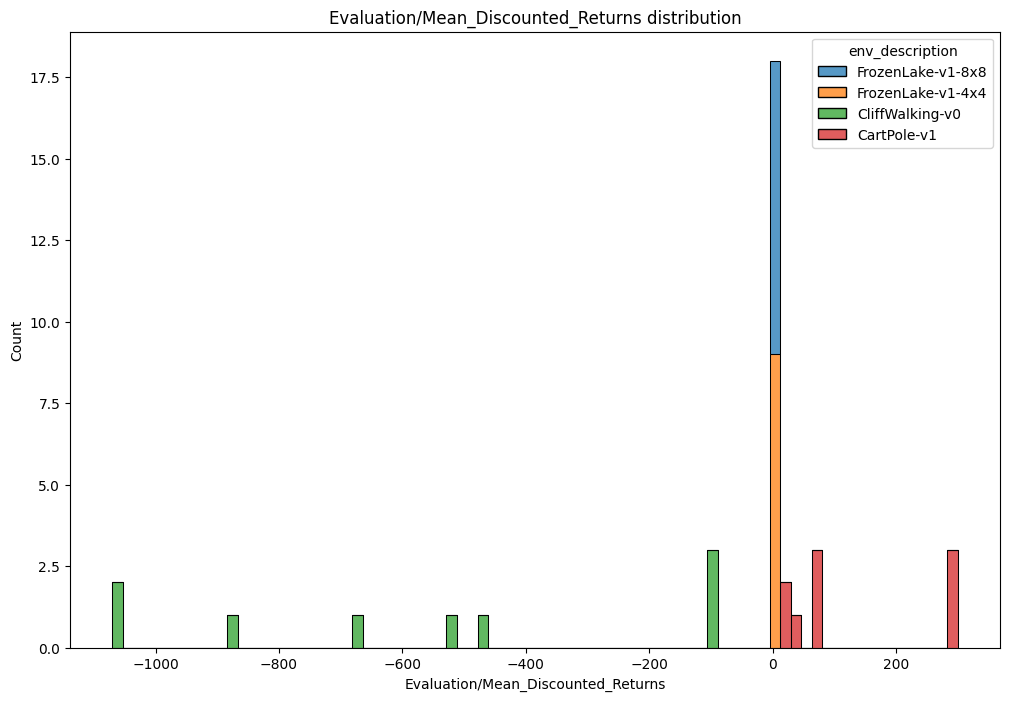

In [106]:
metrics = ['Evaluation/Mean_Discounted_Returns', 'Evaluation/Mean_Entropy', 'Evaluation/Mean_Returns']
metric = metrics[0]
challenge_col = "env_description"

# plot the distribution of metric for each "env_description" and "policy_combination"
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(data=df, x=metric, hue=challenge_col, multiple="stack", ax=ax)
plt.title(f"{metric} distribution")
plt.show()


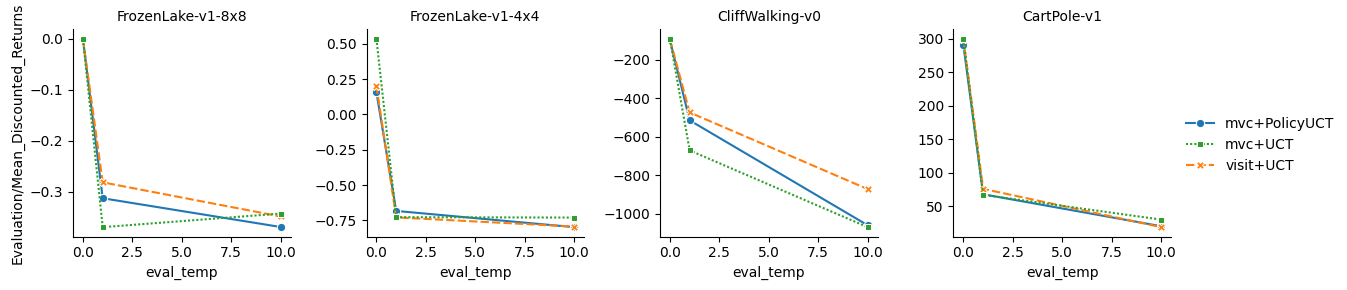

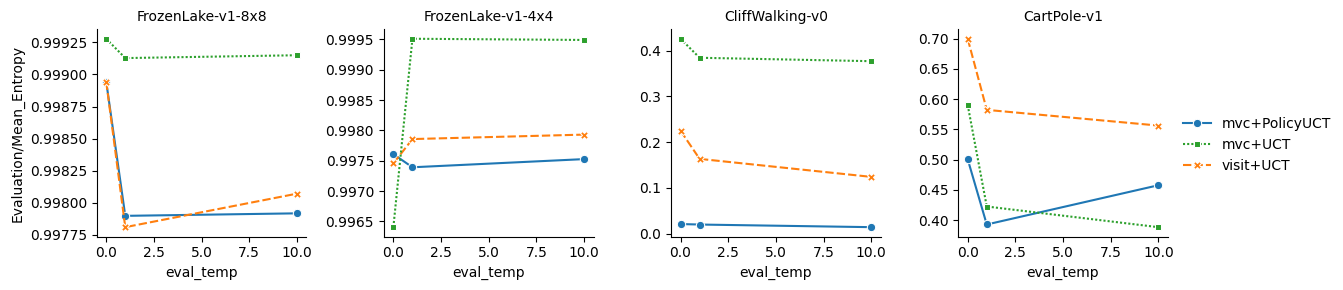

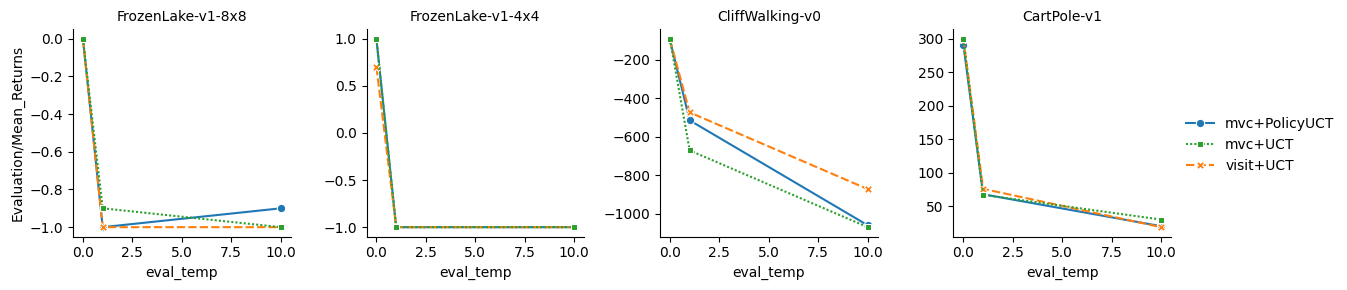

In [110]:




out_folder= "outfiles"

estimator = "mean"
for metric in metrics:
    # Step 1: Set up the FacetGrid to create one subplot for each unique value in 'env_description'
    # Note: adjust size and aspect to fit your data and preference
    g = sns.FacetGrid(df, col=challenge_col,sharex=True, sharey=False)

    # Step 2: Use map_dataframe to draw the lineplots on each subplot
    # Pass sns.lineplot as the plotting function and its arguments
    g.map_dataframe(sns.lineplot,
                    x=x_metric, y=metric,
                    hue="policy_combination", style="policy_combination",
                    markers=True, errorbar="se", estimator=estimator)  # adjust 'estimator' as needed

    # for ax in g.axes.flatten():
    #     ax.set_xscale('log', base=10)

    # Step 3: Adjusting aesthetics (optional)
    # Adding a legend
    g.add_legend()

    # Set the titles for each subplot for clarity
    g.set_titles("{col_name}")

    # Adjust the labels/titles as needed
    g.set_axis_labels(x_metric, metric)

    # clean metric for filename
    metric_filename = metric.replace("/", "_").replace(" ", "_").lower()

    # save pdf in out_folder
    g.savefig(f"{out_folder}/{metric_filename}_{x_metric}.pdf")

    plt.show()